# Long Short Term Memory (LSTM)

A LSTM model is built for each building and stored in a pickled object. LSTM model is built for each first order and second order data.

Importing required libraries

In [1]:
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import sem

Importing required libraries for LSTM architecture

In [2]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


A LSTM model is built of the specified architecture which conforms to the rule of thumb. The model is then applied on test data to measure the root mean squared error (RMSE). 

In [1]:
def invertScaling(scaled, maxT_in):
    '''Converts the scaled data to its original values by multiplying the scaled value with the 
    maximum original value.
    Parameters: scaled data, maximum original value of data
    Return: A numpy array consisting of converted values of scaled data'''
    
    inv = np.array([])
    for y in scaled:
        inv = np.append(inv, y*maxT_in)
    return inv

def lstm(lstm_train_X, lstm_train_y, lstm_test_X, lstm_test_y, maxT_in):
    ''' Builds a LSTM model of specified architecture using the training data. The model is tested by applying 
    it to test data and calculating root mean squared error (RMSE)
    Parameters: training and test data                                             
    Return: LSTM model '''
    
    model = Sequential()
    #Input layer: Number of neurons = Number of features(5)
    model.add(LSTM(5, input_shape=(lstm_train_X.shape[1], lstm_train_X.shape[2])))
    #Hidden layer: Number of neurons = mean of number of neurons in input and output layer
    model.add(Dense(3))
    #Output layer: Number neurons = 1
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
    # fit network
    history = model.fit(lstm_train_X, lstm_train_y, epochs=50, batch_size=72, validation_data=(lstm_test_X, lstm_test_y), verbose=2, shuffle=False)
    
    #apply model to the test data and calculate RMSE
    yhat = model.predict(lstm_test_X)
    inv_yhat = invertScaling(yhat, maxT_in)
    inv_y = invertScaling(lstm_test_y, maxT_in)
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    
    return model

# Autoforecasting

The temperature predictions made for time t + delta, is set as t_in temperature for the index t + delta. And further prediction is made for index t + delta. The error of this prediction is calculated.


In [35]:
def forecastingLSTM(testX_df, testY_df, start_time, duration, lstmmodel, maxT_in, second_order):
    ''' Autoforecasts a sample data of test data. 
    Parameters: test data, start time index, duration till when the forecasting is to be done, 
                lstm model, maximum t_in value, indicator variable for second order
    Return: List of errors of the predictions made for a particular sample '''
    
    predictions_i = []
    errs_i = []
    curr_time = start_time
    #End time index gives till what time autoforecasting is done
    end_time = start_time + datetime.timedelta(minutes=duration)
    while curr_time <= end_time:
        # If current time is not present in test data index then return None
        if curr_time not in testX_df.index:
            return None
        
        #Make a copy of the row of test data having curr_time as its index
        input_x = testX_df.loc[curr_time].copy()
        
        #Previous prediction made is set as t_in for cur_time index data
        if second_order == 1:
            if len(predictions_i) < 2:
                predictions_i.append(input_x['t_in'])
            else:
                input_x['t_in'] = predictions_i[-1]
                input_x['t_in(t-5)'] = predictions_i[-2]
            reshape_param = 2
        else:
            if predictions_i:
                input_x['t_in'] = predictions_i[-1]
            reshape_param = 1
            
        inputX_values = input_x.values
        #Reshape the row accordingly to apply model
        inputX_values = inputX_values.reshape(1,reshape_param,5)
        #Prediction is made for the curr_time row data
        y = lstmmodel.predict([inputX_values])
        #Prediction is stored in a list
        predictions_i.append(y[0])
        #Error is calculated by finding the difference of actual and predicted value of test data
        errs_i.append(testY_df.loc[curr_time]*maxT_in - y[0]*maxT_in)
        curr_time = curr_time + datetime.timedelta(minutes=5)

    return errs_i

In [33]:
def getErrors(testX, testY, startList, duration, model, maxT_in, method, second_order=0):
    ''' Calls the autoforecasting function to get the errors for given samples of test data. 
         Different error metrics are calculated from the errors obtained from autoforecasting
    Parameters: test data, list of time index indicating starting point for samples, 
                duration till when autoforecasting is done, model built to make predictions, maximum t_in value,
                method indicates if its lstm or regression(with or without pca), indicator variable for second order data
    Return: RMSE, MSE, SEM for each interval '''
    
    errs = []
    if method == "lstm":
        #Run the autoforecasting for different samples of data
        for start in startList:
            errs_i = forecastingLSTM(testX, testY, start, duration, model, maxT_in, second_order)
            #Errors collected from each sample is stored as a Series object and appended to a list called errs.
            if errs_i:
                errs.append(pd.Series(index=range(len(errs_i)), data=errs_i))
                
    '''
    elif method == "regression":
        for start in startList:
            errs_i = forecasting(testX, testY, start, duration, model, second_order)
            if errs_i:
                errs.append(pd.Series(index=range(len(errs_i)), data=errs_i))
    elif method == "pca":
        for start in startList:
            errs_i = forecastingPCA(testX, testY, start, duration, model, second_order)
            if errs_i:
                errs.append(pd.Series(index=range(len(errs_i)), data=errs_i))
    '''
    
    final_errors = []
    mean_errors = []
    sem_errors = []
    
    #Calculates different error metrics for each interval. 
    for i in range(int(duration/5)):
        ei = np.array([])
        for e in errs:
            ei = np.append(ei, e.loc[i]*e.loc[i])

        #Calculates the root mean squared error
        final_errors.append(sqrt(np.mean(ei)))
        #Calculates the mean squared error
        mean_errors.append(np.mean(ei))
        #Calculates the standard error of mean
        sem_errors.append(sem(ei))
        
    #plt.errorbar(x=range(len(mean_errors)), y=mean_errors, yerr=sem_errors)
    #plt.show
    return final_errors, mean_errors, sem_errors

# Data Preprocessing 

In [34]:
def readPickleData(filepath):
    ''' Dataset is read from a pickle file.
    Parameters: Location where the data file is stored
    Return: Data read from pickle file '''
    
    with open(filepath, 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            data = u.load()
    return data

def preProcessingData(data, interval, second_order):
    ''' Data collected is further preprocessed to handle the missing data, 
        transform  data for second order data and handle action feature.
        Parameters: data collected, interval at which the prediction should be made, indicator variable for second order
        Return: preprocessed data
    '''
    
    #Converts the categorical value range from 0-5 to 0-2 for action feature
    def f(x):
            if x == 0:
                return 0
            elif x == 2 or x == 5:
                return 2
            elif x ==1 or x == 3:
                return 1
    
    #Construct a feature 'action_heating' and its value is 1 if action is heating else 0
    def h(x):
            if x == 1:
                return 1
            else:
                return 0

    #Construct a feature 'action_cooling' and its value is 1 if action is cooling else 0
    def c(x):
            if x == 2:
                return 1
            else:
                return 0

    data["action"] = data["action"].map(f)
    data['action_heating'] = data["action"].map(h)
    data['action_cooling'] = data['action'].map(c)
    
    #Drop unwanted features
    data = data.drop([ 'action', 'action_prev', 'action_duration'], axis=1)
    
    #Transform the dataset to second order by adding same features having values of previous timestep 
    if second_order==1:
        for col in data:
            last_temps = []

            last_temp = None
            curr_time = data.index[0]
            for index, row in data.iterrows():

                if last_temp is None:
                    last_temps.append(row[col])  # so the feature will be zero instead
                else:
                    last_temps.append(last_temp)

                if curr_time == index:
                    last_temp = row[col]
                    curr_time += datetime.timedelta(seconds=row["dt"])
                else:
                    last_temp = None
                    curr_time = index + datetime.timedelta(seconds=row["dt"])

            data[col+'(t-5)'] = np.array(last_temps)
        data = data.drop(['dt(t-5)'], axis=1)
       
    #Choose the dataset such that the time gaps are set equal to the interval time
    data = data[data["dt"] == interval*60]
    data = data.drop(['dt'], axis=1)
    #Drop missing values
    data = data.dropna()
    
    return data

In [7]:
def scaling(data):
    ''' The values of each feature in dataset are converted to a range 0 to 1 
        by dividing the value with the maximum value of that feature (used for inverting the scalling).
        Parameters: processed data
        Return: converted dataset, list of maximum values of all the features
    '''
    maxValues = []
    scaled = np.empty([data.shape[0], data.shape[1]])
    numSamples = data.shape[0]
    numFeatures = data.shape[1]
    dataValues = data.values
    dataValues = dataValues.astype('float32')
    for i in range(numFeatures):
        maxNum = max(dataValues[:,i])
        maxValues.append(maxNum)
        for j in range(numSamples):
            scaled[j,i] = dataValues[j,i]/maxNum
    return scaled, maxValues

In [8]:
def splitData(processed_data, secondOrder=0):
    ''' The processed data is split into 70% of training and 30% of testing dataset. 
        Each of these datasets are further split into target and features variables.
        Parameters: Processed dataset, indicator variable for second_order
        Return: Features and target variables for training and testing dataset
    '''
    ratio = int(0.7 * processed_data.shape[0])
    train = processed_data.iloc[:ratio]
    test = processed_data.iloc[ratio:]
    if secondOrder==1:
        second_train_y = train['t_next'] #target variable
        second_train_X = train.drop(['t_next', 't_next(t-5)'], axis=1) #remaining variables are features
        second_test_y = test['t_next']
        second_test_X = test.drop(['t_next', 't_next(t-5)'], axis=1)
        return second_train_X,second_train_y,second_test_X,second_test_y 
    train_y = train['t_next'] #target variable
    train_X = train.drop(['t_next'], axis=1) #remaining variables are features
    test_y = test['t_next']
    test_X = test.drop(['t_next'], axis=1)
    return train_X,train_y,test_X,test_y

In [9]:
def reshapeData(trainX, trainY, testX, testY, second_order=0):
    ''' Dataset is reshaped from [samples, features] to [samples, timeframe, features] where
        samples - number of observations(row) in dataset
        timeframe - order of dataset (first order=1, second order=2)
        features - number of attributes(columns) in dataset
        Parameters: Features and target variables of training and testing dataset, indicator variable for second_order
        Return: Reshaped numpy array of features and target variables of training and testing dataset
    '''
    
    if second_order == 1:
        param = 2
    else:
        param = 1
    lstm_train_X = trainX.values.reshape((trainX.shape[0], param, 5))
    lstm_test_X = testX.values.reshape((testX.shape[0], param, 5))
    lstm_train_y = trainY.values
    lstm_test_y = testY.values
    print(lstm_train_X.shape, lstm_train_y.shape, lstm_test_X.shape, lstm_test_y.shape)
    return lstm_train_X, lstm_test_X,lstm_train_y, lstm_test_y

In [46]:
#location where the data file is stored
filepath = "C:/Users/Aishu/Desktop/Project/Aishwarya/Data/hvac_zone_electricalshop.pkl"
#Read dataset and preprocess it
data = readPickleData(filepath)
data = data.drop(data.iloc[:, 8:], axis=1)
processed_data = preProcessingData(data, 5, 0)
second_processed_data = preProcessingData(data, 5, 1)
processed_data.head()

,t_in,t_next,t_out,occ,action_heating,action_cooling
time,,,,,,
2018-12-02 00:25:00+00:00,67.000000,67.3,54.57260,1.0,1,0
2018-12-02 00:30:00+00:00,67.300000,67.9,54.34595,1.0,0,0
2018-12-02 00:35:00+00:00,67.900000,67.6,54.25745,1.0,0,0
2018-12-02 00:40:00+00:00,67.600000,67.2,54.16895,1.0,0,0
2018-12-02 00:49:00+00:00,67.116667,67.1,54.03980,1.0,1,0


In [11]:
second_processed_data.head()

,t_in,t_next,t_out,occ,action_heating,action_cooling,t_in(t-5),t_next(t-5),t_out(t-5),occ(t-5),action_heating(t-5),action_cooling(t-5)
time,,,,,,,,,,,,
2018-12-02 01:01:00+00:00,68.0,67.9,53.5649,0.0,0,0,68.0,68.0,53.8700,0.0,1.0,0.0
2018-12-02 01:06:00+00:00,67.9,67.9,53.2598,0.0,0,0,68.0,67.9,53.5649,0.0,0.0,0.0
2018-12-02 01:11:00+00:00,67.9,67.9,52.9547,0.0,0,0,67.9,67.9,53.2598,0.0,0.0,0.0
2018-12-02 01:16:00+00:00,67.9,67.8,52.9547,0.0,0,0,67.9,67.9,52.9547,0.0,0.0,0.0
2018-12-02 01:21:00+00:00,67.8,67.8,52.9547,0.0,0,0,67.9,67.8,52.9547,0.0,0.0,0.0


In [47]:
#Standardize the processed data and store it in a dataframe
scaled, scalers = scaling(processed_data)
scaled = pd.DataFrame(data=scaled, index=processed_data.index, columns=['t_next', 't_in', 't_out', 'occ', 'action_heating', 'action_cooling'])
second_scaled, second_scalers = scaling(second_processed_data)
second_scaled = pd.DataFrame(data=second_scaled, index=second_processed_data.index, columns=['t_next', 't_in', 't_out', 'occ', 'action_heating', 'action_cooling', 't_next(t-5)', 't_in(t-5)', 't_out(t-5)', 'occ(t-5)', 'action_heating(t-5)', 'action_cooling(t-5)'])
second_scaled.head()

,t_next,t_in,t_out,occ,action_heating,action_cooling,t_next(t-5),t_in(t-5),t_out(t-5),occ(t-5),action_heating(t-5),action_cooling(t-5)
time,,,,,,,,,,,,
2018-12-02 00:25:00+00:00,0.899329,0.903356,0.764050,1.0,1.0,0.0,0.899329,0.903356,0.764050,1.0,1.0,0.0
2018-12-02 00:30:00+00:00,0.903356,0.911409,0.760877,1.0,0.0,0.0,0.899329,0.903356,0.764050,1.0,1.0,0.0
2018-12-02 00:35:00+00:00,0.911409,0.907383,0.759638,1.0,0.0,0.0,0.903356,0.911409,0.760877,1.0,0.0,0.0
2018-12-02 00:40:00+00:00,0.907383,0.902013,0.758399,1.0,0.0,0.0,0.911409,0.907383,0.759638,1.0,0.0,0.0
2018-12-02 00:49:00+00:00,0.900895,0.900671,0.756591,1.0,1.0,0.0,0.902013,0.900895,0.757185,1.0,0.0,0.0


In [48]:
#Split the dataset
trainX_df, trainY_df, testX_df, testY_df = splitData(scaled)
second_trainX_df, second_trainY_df, second_testX_df, second_testY_df = splitData(second_scaled,1)
second_trainX_df.head()

,t_in,t_out,occ,action_heating,action_cooling,t_in(t-5),t_out(t-5),occ(t-5),action_heating(t-5),action_cooling(t-5)
time,,,,,,,,,,
2018-12-02 00:25:00+00:00,0.903356,0.764050,1.0,1.0,0.0,0.903356,0.764050,1.0,1.0,0.0
2018-12-02 00:30:00+00:00,0.911409,0.760877,1.0,0.0,0.0,0.903356,0.764050,1.0,1.0,0.0
2018-12-02 00:35:00+00:00,0.907383,0.759638,1.0,0.0,0.0,0.911409,0.760877,1.0,0.0,0.0
2018-12-02 00:40:00+00:00,0.902013,0.758399,1.0,0.0,0.0,0.907383,0.759638,1.0,0.0,0.0
2018-12-02 00:49:00+00:00,0.900671,0.756591,1.0,1.0,0.0,0.900895,0.757185,1.0,0.0,0.0


In [49]:
#Reshape the dataset
lstm_train_X, lstm_test_X,lstm_train_y, lstm_test_y = reshapeData(trainX_df, trainY_df, testX_df, testY_df)
second_lstm_train_X, second_lstm_test_X,second_lstm_train_y, second_lstm_test_y = reshapeData(second_trainX_df, second_trainY_df, second_testX_df, second_testY_df,1 )

(14090, 1, 5) (14090,) (6039, 1, 5) (6039,)
(14090, 2, 5) (14090,) (6039, 2, 5) (6039,)


In [73]:
#Build a LSTM model for first order dataset
lstmModel = lstm(lstm_train_X, lstm_train_y, lstm_test_X, lstm_test_y, scalers[1])

Train on 14090 samples, validate on 6039 samples
Epoch 1/50
 - 13s - loss: 0.2902 - acc: 0.0000e+00 - val_loss: 0.0237 - val_acc: 3.3118e-04
Epoch 2/50
 - 1s - loss: 0.0186 - acc: 0.0000e+00 - val_loss: 0.0177 - val_acc: 3.3118e-04
Epoch 3/50
 - 1s - loss: 0.0135 - acc: 0.0000e+00 - val_loss: 0.0162 - val_acc: 3.3118e-04
Epoch 4/50
 - 1s - loss: 0.0127 - acc: 0.0000e+00 - val_loss: 0.0154 - val_acc: 3.3118e-04
Epoch 5/50
 - 1s - loss: 0.0122 - acc: 0.0000e+00 - val_loss: 0.0147 - val_acc: 3.3118e-04
Epoch 6/50
 - 1s - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.0142 - val_acc: 3.3118e-04
Epoch 7/50
 - 1s - loss: 0.0112 - acc: 0.0000e+00 - val_loss: 0.0139 - val_acc: 3.3118e-04
Epoch 8/50
 - 1s - loss: 0.0108 - acc: 0.0000e+00 - val_loss: 0.0130 - val_acc: 3.3118e-04
Epoch 9/50
 - 1s - loss: 0.0105 - acc: 0.0000e+00 - val_loss: 0.0128 - val_acc: 3.3118e-04
Epoch 10/50
 - 1s - loss: 0.0105 - acc: 0.0000e+00 - val_loss: 0.0123 - val_acc: 3.3118e-04
Epoch 11/50
 - 1s - loss: 0.0102 - acc:

In [74]:
#Build the model several times (as initial weights are random numbers) and 
#store the lstm model giving best result into a pickle object
pickle_out = open("facmaindept_lstm1b.pickle","wb")
pickle.dump(lstmModel, pickle_out)
pickle_out.close()

In [75]:
#Build a lstm model for second order data
second_lstmModel = lstm(second_lstm_train_X, second_lstm_train_y, second_lstm_test_X, second_lstm_test_y, second_scalers[1])

Train on 14090 samples, validate on 6039 samples
Epoch 1/50
 - 12s - loss: 0.4296 - acc: 0.0000e+00 - val_loss: 0.0213 - val_acc: 3.3118e-04
Epoch 2/50
 - 1s - loss: 0.0150 - acc: 0.0000e+00 - val_loss: 0.0227 - val_acc: 3.3118e-04
Epoch 3/50
 - 1s - loss: 0.0123 - acc: 0.0000e+00 - val_loss: 0.0230 - val_acc: 3.3118e-04
Epoch 4/50
 - 1s - loss: 0.0122 - acc: 0.0000e+00 - val_loss: 0.0226 - val_acc: 3.3118e-04
Epoch 5/50
 - 2s - loss: 0.0120 - acc: 0.0000e+00 - val_loss: 0.0214 - val_acc: 3.3118e-04
Epoch 6/50
 - 1s - loss: 0.0121 - acc: 0.0000e+00 - val_loss: 0.0234 - val_acc: 3.3118e-04
Epoch 7/50
 - 1s - loss: 0.0118 - acc: 0.0000e+00 - val_loss: 0.0217 - val_acc: 3.3118e-04
Epoch 8/50
 - 1s - loss: 0.0117 - acc: 0.0000e+00 - val_loss: 0.0225 - val_acc: 3.3118e-04
Epoch 9/50
 - 2s - loss: 0.0116 - acc: 0.0000e+00 - val_loss: 0.0221 - val_acc: 3.3118e-04
Epoch 10/50
 - 1s - loss: 0.0116 - acc: 0.0000e+00 - val_loss: 0.0226 - val_acc: 3.3118e-04
Epoch 11/50
 - 1s - loss: 0.0114 - acc:

In [76]:
#Build the model several times (as initial weights are random numbers) and 
#store the lstm model giving best result into a pickle object
pickle_out = open("facmaindept_lstm2b.pickle","wb")
pickle.dump(second_lstmModel, pickle_out)
pickle_out.close()

In [77]:
#Read the pickle object to get the best lstm model (first and second order) 
fileObject1 = open("facmaindept_lstm1b.pickle", 'rb')  
lstmModel = pickle.load(fileObject1) 
fileObject2 = open("facmaindept_lstm2b.pickle", 'rb') 
second_lstmModel = pickle.load(fileObject2) 

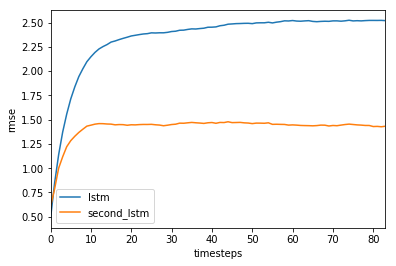

,lstm,second_lstm
0,0.487797,0.607149
1,0.847055,0.786566
2,1.138501,0.999885
3,1.371824,1.117544
4,1.556954,1.221066


In [78]:
#Evaluate the model for 800 samples for a duration of 7 hours and plot the rmse values
startSamples = testX_df.sample(n=800)
startList = startSamples.index
duration = 60 * 7

df_errors = pd.DataFrame()

#Calculate the error metrics
df_errors['lstm'], lstm_mean, lstm_sem = getErrors(testX_df, testY_df, startList, duration, lstmModel, scalers[1], "lstm")
df_errors['second_lstm'], second_lstm_mean, second_lstm_sem = getErrors(second_testX_df, second_testY_df, startList, duration, second_lstmModel, second_scalers[1], "lstm", 1)


df_errors.plot()
plt.xlabel('timesteps')
plt.ylabel('rmse')
plt.show()
df_errors.head()